In [4]:
""" import useful functions """

# Generic
import pandas as pd
import numpy as np
import scipy
import sys
from itertools import islice, cycle
import math
import os
import sys
from scipy.integrate import odeint
from joblib import Parallel, delayed

# cosmology
import pyccl as ccl
import tjpcov as tjp
from tjpcov.covariance_calculator import CovarianceCalculator
from astropy.io import fits
import yaml
import sacc
import time

# Generate data sets
from sklearn.datasets import make_blobs

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# MCMC
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from IPython.display import display, Math

# nDGP NL and lin Pk
from nDGPemu import BoostPredictor
MODULE_PATH = "/home/c2042999/MGCAMB/camb/__init__.py"
MODULE_NAME = "MGCAMB"
import importlib
spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module 
spec.loader.exec_module(module)
from MGCAMB import camb

In [5]:
"""For tests"""
cosmo = ccl.Cosmology(Omega_c = (0.1417493400784 - 0.0223)/0.67**2,
                           Omega_b =  0.0223/0.67**2,
                           h = 0.67,
                           n_s = 0.9665,
                           A_s = 2.01e-9)

# 1. Create mock redshift distribution (define z and output Binned_distribution(z))

In [6]:
""" Get a binned redshift distribution - defining functions """
"""This will come from the dataset we decide to test"""

# define the reasonable redshift distribution (not normalized yet)

def redshiftdist(z):
    """
    Defines a reasonable redshift distribution (not normalized yet)
    input:
        redshift z: numpy.array with dim:N
    returns:
        redshift distribution p(z): numpy.array with dim:N
    """
    alpha = 2
    beta = 0.78
    z0 = 0.13
    pz = z**alpha * np.exp(-(z / z0)**beta)
    return pz

def bindist(z, n_bins):
    """
    Finds redshift bins so that integral of p(z) over each bin stays the same.
    (in limit of large len(z))
    input:
        redshift z: numpy.array with dim:N
        number of bins n_bins: int (value M)
    returns:
        redshift bin edges: numpy.array with dim:M+1
    """
    # have redshiftdist(z), z 
    # find bins: integrate between 0 and i redshift(z)
    #            if integral => 1/n_bin, that is a bin
    #            repeat for 2/n_bin, 3/n_bin, etc
    pz = redshiftdist(z)
    N = scipy.integrate.simps(pz, z)                                      # Normalization factor
    pz = pz/N                                                             # Normalize p(z)
    j = 1
    bins = np.zeros(int(n_bins + 1))
    for i in range(len(z) - 10):
        I = scipy.integrate.simps(pz[0 : i + 10], z[0 : i + 10])
        if I >= j / n_bins:
            bins[j] = z[i + 10]
            j += 1
    bins[int(n_bins)] = z[len(z) - 1]
    bins[0] = z[0]
    return bins

def gaussianphotoz(zs , zp):
    """
    Finds gaussian photo-z uncertainties
    """
    I = np.exp(-np.power(zs - zp , 2.) / (2 * np.power(0.05 * (1 + zp) , 2.)))
    N = scipy.integrate.simps(I , zs)
    return I/(N)

def binning_redshiftdist(z , n_bins):
    """
    bins distribution for p(z) in n_bins with same number of galaxies in each bin, 
    smoothened by gaussianphotoz(zs , zp) kernel
    input:
        redshift z: numpy.array with dim:N
        number of bins n_bins: int of size M
    returns:
        binned redshift distribution: numpy.array with dim:(N,M)
        sum: p(z) recovered by summing over all binned redshift distributions: numpy.array with dim:N
    """
    N = scipy.integrate.simps(redshiftdist(z), z)

    # complete binning
    bin_edges = bindist(z, n_bins)

    # smoothing redshift distribution with gaussian kernel
    Sum = 0                                                                       # find what the sum of normalized plots is. Want this equal to Rdist
    binned_redshiftdist = np.zeros((len(bin_edges) - 1, len(z)))

    for i in range(len(bin_edges) - 1):
        Rdist_new = np.zeros(len(z))
        conv = np.zeros(len(z))

        for j in range(len(z)):                                                  # define binned redshift functions before smoothing
            if z[j] >= bin_edges[i] and z[j] <= bin_edges[i+1]:
                Rdist_new[j] = redshiftdist(z[j])/(N)
    
        for j in range(len(z)):                                                  # smoothen distributions by convolving with a gaussian kernel
            conv[j] = scipy.integrate.simps(Rdist_new * gaussianphotoz(z , z[j]) , z)
    
        binned_redshiftdist[i] = conv
    
        Sum += conv
    
    #plt.plot(zp, conv)
    return binned_redshiftdist , Sum

In [7]:
""" Get a binned redshift distribution - getting the actual distribution """

# find normalized redshift distribution

z = np.linspace(0.001 , 3.0 , 256)

Rdist = redshiftdist(z)
N = scipy.integrate.simps(Rdist, z)                                    # Normalization factor
Rdist = Rdist/N

Binned_distribution = binning_redshiftdist(z , 5)[0]

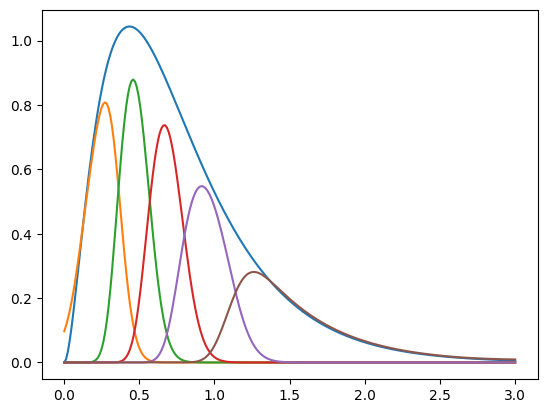

In [8]:
## TEST2: Plots to check binned redshift distribution


plt.plot(z , Rdist)
plt.plot(z ,Binned_distribution[0])
plt.plot(z ,Binned_distribution[1])
plt.plot(z ,Binned_distribution[2])
plt.plot(z ,Binned_distribution[3])
plt.plot(z ,Binned_distribution[len(Binned_distribution)-1])


# 2. Define functions to get various (P(k)) from Emulators, etc.

The power spectrum in $\Lambda$CDM and nDGP is the same in the early universe (i.e. $\approx z=49$). This means we have:

$P_{\delta}(z=49) = \Big(\frac{\delta^{\Lambda CDM}(z=49)}{\delta^{\Lambda CDM}(z=0)}\Big)^2P^{\Lambda CDM}_{\delta}(z=0) = \Big(\frac{\delta^{nDGP}(z=49)}{\delta^{nDGP}(z=z_{ini})}\Big)^2P^{nDGP}_{\delta}(z=z_{ini})$

Therefore 

$P^{nDGP}_{\delta}(z=z_{ini}) = \Big(\frac{D_+^{\Lambda CDM}(z=49)}{D_+^{nDGP}(z=49)} \times \frac{D_+^{nDGP}(z=z_{ini})}{D_+^{\Lambda CDM}(z=z_{ini})}
\Big)^2P^{\Lambda CDM}_{\delta}(z=0)$

where $D_+(z=0) = 1$.

In [70]:
""" define useful functions"""

# NL matter power spectra in nDGP
def P_k_NL_nDGP(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n))
    
    output Pk_nDGP (array) -> Nonlinear matter power spectrum for nDGP gravity, units (Mpc)^3
    """
    # Turn k into units of h/Mpc
    k = k/cosmo["h"]

    H0rc, fR0, n = MGparams

    # nDGP emulator - get boost
    cosmo_params = {'Om':cosmo["Omega_m"],
                    'ns':cosmo["n_s"],
                    'As':cosmo["A_s"],
                    'h':cosmo["h"],
                    'Ob':cosmo["Omega_b"]}
    pkratio_nDGP = model_nDGP.predict(H0rc, 1/a -1 , cosmo_params, k_out=k)

    # Get GR power spectrum
    
    Pk_ccl = ccl.power.nonlin_power(cosmo, k*cosmo["h"], a=a) # units (Mpc)^3
    return pkratio_nDGP*Pk_ccl

# TOCHANGE: NL matter power spectra in fR
def P_k_NL_fR(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n))
    
    output Pk_fR (array) -> Nonlinear matter power spectrum for Hu-Sawicki fR gravity, units (Mpc)^3
    """
    return P_k_NL_nDGP(cosmo, MGparams, k, a)

"""Functions for linear Pk"""

# dimensionless hubble parameter in GR
def E(cosmoMCMCStep, a):
    Omg_r = cosmoMCMCStep["Omega_g"]*(1+ 3.046*7/8 * (4/11)**(7/8))
    return np.sqrt(cosmoMCMCStep["Omega_m"]/a**3 +Omg_r/a**4 + (1 - cosmoMCMCStep["Omega_m"] - Omg_r))

# deriv. of E wrt scale factor, GR
def dEda(cosmo, a):
    Omg_r = cosmo["Omega_g"]*(1+ 3.046*7/8 * (4/11)**(7/8))
    E_val = E(cosmo, a)
    
    return (-3*cosmo["Omega_m"]/a**4 -4*Omg_r/a**5)/2/E_val

# mu(k,a) = mu(a) in nDGP (modified gravity parametrization parameter)
def mu_nDGP(Omg_rc, cosmo, a):
    if Omg_rc == 0:
        return 1
    else:
        E_val = E(cosmo, a)
        beta = 1 + E_val/np.sqrt(Omg_rc) * (1+ a*dEda(cosmo, a)/3/E_val)
        return 1 + 1/3/beta
    
def solverGrowth(y,a,cosmo, Omg_rc):
    E_val = E(cosmo, a)
    D , a3EdDda = y
    
    ydot = [a3EdDda / (E_val*a**3), 3*cosmo["Omega_m"]*D*(mu_nDGP(Omg_rc, cosmo, a))/(2*E_val*a**2)]
    return ydot
    
def P_k_nDGP_lin(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n))
    
    output Pk_nDGP (array) -> linear matter power spectrum for nDGP gravity, units (Mpc)^3
    """
    
    # Get growth factor in nDGP and GR
    H0rc, fR0, n = MGparams
    
    Omega_rc = 1/(4*H0rc**2)
    
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth, [a_solver[0], (E(cosmo, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmo,Omega_rc), mxstep=int(1e4))
    
    Delta = Soln.T[0]/Soln.T[0][-1]
    Soln = odeint(solverGrowth, [a_solver[0], (E(cosmo, a_solver[0])*a_solver[0]**3)], a_solver,\
                  args=(cosmo,0), mxstep=int(1e4))
    
    Delta_GR = Soln.T[0]/Soln.T[0][-1]

    # Get Pk linear in GR
    
    Pk_GR = ccl.linear_matter_power(cosmo, k=k, a=a)

    Delta_nDGP_49 = Delta[0]
    Delta_GR_49 = Delta_GR[0]
    return Pk_GR * (Delta_GR_49 / Delta_nDGP_49) **2   # units (Mpc)^3


## WILL HAVE TO CHANGE: for now same as nDGP but different MG param
def P_k_fR_lin(cosmo, MGparams, k, a):
    return P_k_nDGP_lin(cosmo, MGparams, k, a)


In [71]:
# Get Pk for each MCMC step - mu sigma param TODO CHECK THIS IS CORRECT WITH DANIELLE
# for now assume sigma = 1

def solverGrowth_musigma(y,a,cosmoMCMCStep, mu):
    E_val = E(cosmoMCMCStep, a)
    D , a3EdDda = y
    
    ydot = [a3EdDda / (E_val*a**3), 3*cosmoMCMCStep["Omega_m"]*D*(1 + mu/E_val**2)/(2*E_val*a**2)]
    return ydot
    
def P_k_musigma(cosmoMCMCStep, mu, k, a):
    
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n))
    
    output P_k_musigma (array) -> linear matter power spectrum for mu sigma param, units (Mpc)^3
    """
    
    # Get growth factor in nDGP and GR
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth_musigma, [a_solver[0], (E(cosmoMCMCStep, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmoMCMCStep,mu), mxstep=int(1e4))
    
    Delta = Soln.T[0]/Soln.T[0][-1]
    Soln = odeint(solverGrowth, [a_solver[0], (E(cosmoMCMCStep, a_solver[0])*a_solver[0]**3)], a_solver,\
                  args=(cosmoMCMCStep,0.0), mxstep=int(1e4))
    
    Delta_GR = Soln.T[0]/Soln.T[0][-1]

    # Get Pk linear in GR
    Pk_GR = ccl.linear_matter_power(cosmoMCMCStep, k=k, a=a)

    Delta_nDGP_49 = Delta[0]
    Delta_GR_49 = Delta_GR[0]
    return Pk_GR * (Delta_GR_49 / Delta_nDGP_49) **2    # units (Mpc)^3


In [72]:
"""Initialize some things (e.g. emulators and MGCAMB)"""
# Load the nDGP emulator
model_nDGP = BoostPredictor()

# Initialize MGCAMB
pars = camb.CAMBparams()


Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 2.a. Test functions for P(k)

(58,)
(12, 58)
(12, 58)


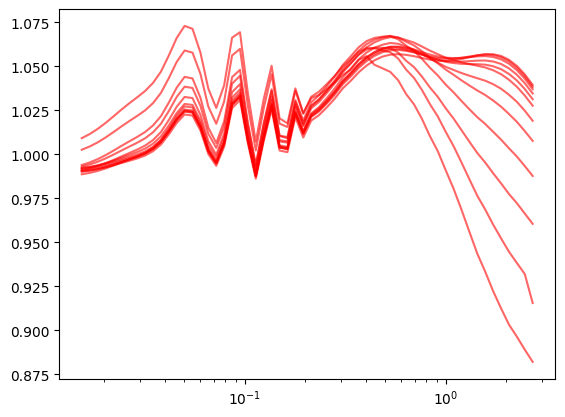

In [73]:
"""Test nDP P(k)"""
"""Load ReACT pre-made plots"""

# nDGP
arr = np.loadtxt("/home/c2042999/REACT_inst2/Lin_NL_nDGP_pk.txt")

# Cosmo and MG parameters same as in ReACT
Omegarc_arr = np.logspace(np.log10(0.2),np.log10(20)-0.001,12)

k_ReACT = arr[0][60:-10] * cosmo["h"] # 1/Mpc
print(k_ReACT.shape)
pofk_lin_MG_react = arr[13:][:,60:-10] / cosmo["h"]**3 # Mpc^3
print(pofk_lin_MG_react.shape)
pofk_NL_MG_react = arr[1:13][:,60:-10]  / cosmo["h"]**3 # Mpc^3
print(pofk_NL_MG_react.shape)


for i in range(len(Omegarc_arr)):
    Pk_nDGP_NL_test = P_k_NL_nDGP(cosmo, [Omegarc_arr[i],0,0], k_ReACT, 1)
    Pk_nDGP_lin_test = P_k_nDGP_lin(cosmo, [Omegarc_arr[i],0,0], k_ReACT, 1)
    plt.semilogx(k_ReACT, (Pk_nDGP_NL_test/Pk_nDGP_lin_test) / (pofk_NL_MG_react[i]/pofk_lin_MG_react[i]), "r", alpha=0.6)

In [74]:
"""Test nDGP with extended k,a"""
def pk_func(cosmo, MGParams, k, a):
        # condition on z
        if (1/a - 1) > 2:
            val = ccl.nonlin_matter_power(cosmo, k=k, a=a)
            return val
        else:
            idx_min = np.argmin(np.abs(k - 0.0156606*cosmo["h"])) + 1
            idx_max = np.argmin(np.abs(k - 4.99465*cosmo["h"])) -1
            k_allowed = k[idx_min:idx_max]
            pk = np.append(np.append(P_k_nDGP_lin(cosmo, MGParams, k[:idx_min], a),P_k_NL_nDGP(cosmo, MGParams, k_allowed, a)),
                           ccl.nonlin_matter_power(cosmo, k=k[idx_max:], a=a))
            return pk

In [75]:
k_test = np.logspace(-4, 4, 100)
idx_max = np.argmin(np.abs(k_test - 4.99465*cosmo["h"])) - 1

pk_test = pk_func(cosmo, [0.2,0,0], k_test, 1)
pk_test_lin = P_k_nDGP_lin(cosmo, [0.2,0,0], k_test, 1)
pk_test1 = pk_func(cosmo, [20,0,0], k_test, 1)
pk_test1_lin = P_k_nDGP_lin(cosmo, [20,0,0], k_test, 1)

pk_GR_test = ccl.nonlin_matter_power(cosmo, k=k_test, a=1)
pk_GR_test_lin = ccl.linear_matter_power(cosmo, k=k_test, a=1)


(100.0, 200000.0)

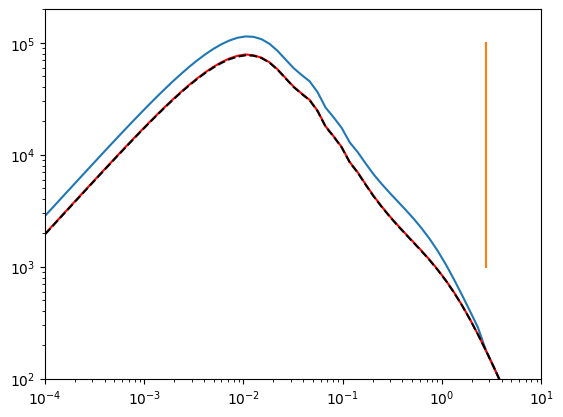

In [76]:
plt.loglog(k_test,pk_test)
#plt.loglog(k_test,pk_test_lin)
plt.loglog(k_test,pk_test1, "r")
#plt.loglog(k_test,pk_test1_lin, "r")
plt.loglog(k_test,pk_GR_test, "k--")
#plt.loglog(k_test,pk_GR_test_lin, "k--")
plt.loglog(k_test[idx_max]*np.array([1,1]), [1e3,1e5])
plt.xlim(1e-4,1e1)
plt.ylim(1e2,2e5)

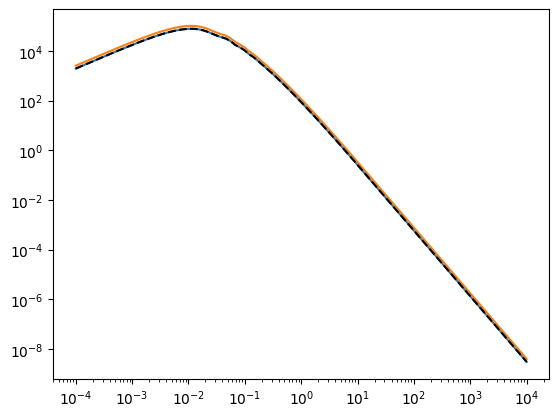

In [77]:
"""Test mu sigma param"""

plt.loglog(k_test, P_k_musigma(cosmo, 0.0, k_test, 1))
plt.loglog(k_test, P_k_musigma(cosmo, 1.1, k_test, 1))
plt.loglog(k_test,pk_GR_test_lin, "k--")

# 3. Getting C(ell) functions

## 3a. Function for angular power spectrum (lensing-lensing) (C_ell) from a given P_del(k, a) = pk_func(k, a)

In [174]:
def Cell(ell_min, ell_max, ell_bin_num, cosmo, z, Binned_distribution, pk_F, MGParams):
    """
    Finds C^{i,j}(ell) for {i,j} redshift bins (shape-shape angular power spectrum).
    input:
        redshift z: numpy.array with dim:N
        binned redshift dist: numpy.array with dim:(N,M) (M = no. z bins)
        minimum value of ell: int
        maximum value of ell: int
        number of ell bins: int (value P)
        pk_F: function (cosmo, MGParams, k,a) for k (in 1/Mpc), returns matter power spectrum (in Mpc^3)
    returns:
        ell bins: numpy.array with dim:P*(M+1)*M/2
        C_ell: numpy.array with dim:P*(M+1)*M/2
    """
    # define quantities for binning in ell
    ell_binned_limits = np.linspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = 10**((bin_edge1 + bin_edge2) / 2)
    
    # Find NL power spectrum at given cosmo
    def pk_func(k, a):
        # condition on z
        if (1/a - 1) > 2:
            val = ccl.nonlin_matter_power(cosmo, k=k, a=a)
            return val
        else:
            idx_min = np.argmin(np.abs(k - 0.0156606*cosmo["h"])) + 1
            idx_max = np.argmin(np.abs(k - 4.99465*cosmo["h"])) - 1
            k_allowed = k[idx_min:idx_max]
            pk = np.append(np.append(P_k_nDGP_lin(cosmo, MGParams, k[:idx_min], a),pk_F(cosmo, MGParams, k_allowed, a)),
                           ccl.nonlin_matter_power(cosmo, k=k[idx_max:], a=a))
            return pk
        #else: 
        #    return pk_F(cosmo, MGParams, k, a)

    P_delta2D = ccl.pk2d.Pk2D.from_function(pkfunc=pk_func, is_logp=False)

    C_ell_array = []
    
    for j in range(len(Binned_distribution)):
        tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution[j]))
        for k in range(len(Binned_distribution)):
            if k >= j:
                tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution[k]))
                C_ell = ccl.angular_cl(cosmo, tracer1, tracer2, ell_binned, p_of_k_a=P_delta2D)
    
                C_ell_array = np.append(C_ell_array, [C_ell])
                
    # Repeat ell_binned over all redshift bins, so that len(ell_binned)=len(C_ell_array)
    ell_binned = list(islice(cycle(ell_binned), int(ell_bin_num*((len(Binned_distribution)+1)*len(Binned_distribution))/2)))
    
    return ell_binned, C_ell_array

In [175]:
def Cell_GR(ell_min, ell_max, ell_bin_num, cosmo, z, Binned_distribution, pk_2D_obj, MGParams):
    """
    Finds C^{i,j}(ell) for {i,j} redshift bins (shape-shape angular power spectrum).
    input:
        redshift z: numpy.array with dim:N
        binned redshift dist: numpy.array with dim:(N,M) (M = no. z bins)
        minimum value of ell: int
        maximum value of ell: int
        number of ell bins: int (value P)
        pk_2D_obj: "linear" or "non-linear", describes kind of power spec
    returns:
        ell bins: numpy.array with dim:P*(M+1)*M/2
        C_ell: numpy.array with dim:P*(M+1)*M/2
    """

    # define quantities for binning in ell
    ell_binned_limits = np.linspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = 10**((bin_edge1 + bin_edge2) / 2)

    # Find NL power spectrum at given cosmo
    def pk_func(k, a):
        if pk_2D_obj =="linear":
            return ccl.linear_matter_power(cosmo, k=k, a=a)
        else:
            return ccl.nonlin_matter_power(cosmo, k=k, a=a)

    P_delta2D = ccl.pk2d.Pk2D.from_function(pkfunc=pk_func, is_logp=False)
    
    C_ell_array = []
    
    for j in range(len(Binned_distribution)):
        tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution[j]))
        for k in range(len(Binned_distribution)):
            if k >= j:
                tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution[k]))
                C_ell = ccl.angular_cl(cosmo, tracer1, tracer2, ell_binned, p_of_k_a=P_delta2D)
    
                C_ell_array = np.append(C_ell_array, [C_ell])
    
    # Repeat ell_binned over all redshift bins, so that len(ell_binned)=len(C_ell_array)
    ell_binned = list(islice(cycle(ell_binned), int(ell_bin_num*((len(Binned_distribution)+1)*len(Binned_distribution))/2)))
    
    return ell_binned, C_ell_array

In [176]:
def Cell_linear(ell_min, ell_max, ell_bin_num, cosmoMCMCStep, z, Binned_distribution, pk_F, MGParams):
    """
    Finds C^{i,j}(ell) for {i,j} redshift bins (shape-shape angular power spectrum).
    input:
        redshift z: numpy.array with dim:N
        binned redshift dist: numpy.array with dim:(N,M) (M = no. z bins)
        minimum value of ell: int
        maximum value of ell: int
        number of ell bins: int (value P)
        pk_F: function (cosmo, MGParams, k,a) for k (in 1/Mpc), returns matter power spectrum (in Mpc^3)
    returns:
        ell bins: numpy.array with dim:P*(M+1)*M/2
        C_ell: numpy.array with dim:P*(M+1)*M/2
    """

    # define quantities for binning in ell
    ell_binned_limits = np.linspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = 10**((bin_edge1 + bin_edge2) / 2)

    # Find NL power spectrum at given cosmo
    def pk_func(k, a):
        # condition on z
        return pk_F(cosmoMCMCStep, MGParams, k, a)

    P_delta2D = ccl.pk2d.Pk2D.from_function(pkfunc=pk_func, is_logp=False)
    
    C_ell_array = []

    for j in range(len(Binned_distribution)):
        tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution[j]))
        for k in range(len(Binned_distribution)):
            if k >= j:
                tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution[k]))
                C_ell = ccl.angular_cl(cosmo, tracer1, tracer2, ell_binned, p_of_k_a=P_delta2D)
    
                C_ell_array = np.append(C_ell_array, [C_ell])
    
    # Repeat ell_binned over all redshift bins, so that len(ell_binned)=len(C_ell_array)
    ell_binned = list(islice(cycle(ell_binned), int(ell_bin_num*((len(Binned_distribution)+1)*len(Binned_distribution))/2)))
    
    return ell_binned, C_ell_array
    

## 3b. Test these functions

In [177]:
"""Test C(ell) function"""


"""MG"""
# find C_ell for non-linear matter power spectrum
start = time.time()
testdata = Cell(10, 2000, 18, \
                cosmo, z , Binned_distribution, P_k_NL_nDGP, [0.2,0,0]) # For now GR

print("time1 = ", time.time() - start)

ell_testdata = testdata[0]
D_testdata = testdata[1]

D_testdata = (np.array(D_testdata)).flatten()

start = time.time()
testdata_lin = Cell_linear(10, 2000, 18, \
                cosmo, z , Binned_distribution, P_k_nDGP_lin, [0.2,0,0]) # For now GR
print("time2 = ", time.time() - start)

D_testdata_lin = testdata_lin[1]
D_testdata_lin = (np.array(D_testdata_lin)).flatten()

del testdata, testdata_lin

"""GR"""
# find C_ell for non-linear matter power spectrum
start = time.time()
testdata_GR = Cell_GR(10, 2000, 18, \
                cosmo, z , Binned_distribution, "non-linear", [0.2,0,0])
print("time3 = ", time.time() - start)

D_testdata_GR = testdata_GR[1]
D_testdata_GR = (np.array(D_testdata_GR)).flatten()

start = time.time()
testdata_GR_lin = Cell_GR(10, 2000, 18, \
                cosmo, z , Binned_distribution, "linear", [0,0,0])
print("time4 = ", time.time() - start)

D_testdata_GR_lin = testdata_GR_lin[1]
D_testdata_GR_lin = (np.array(D_testdata_GR_lin)).flatten()

del testdata_GR, testdata_GR_lin

time1 =  0.19283485412597656
time2 =  0.2888045310974121
time3 =  0.037270307540893555
time4 =  0.03800201416015625


(270,)
(270,)
(270,)


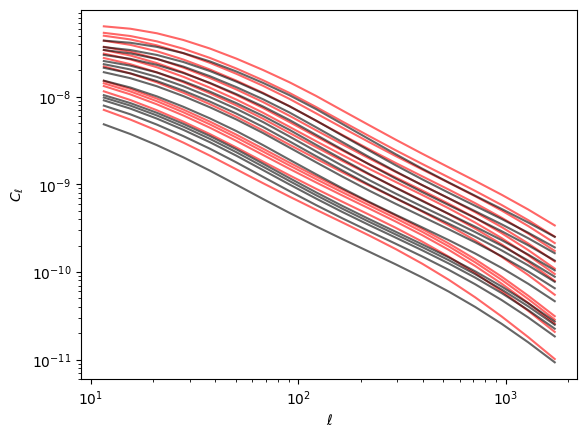

In [178]:
"""Plots: Test C(ell) function"""

ell_bin_number = 18
print(D_testdata.shape)
print(D_testdata_GR.shape)
print(D_testdata_lin.shape)

for j in range(int(len(D_testdata)/ell_bin_number) - 1):
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata[j*ell_bin_number:(j+1)*ell_bin_number], "r", alpha= 0.6)
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata_GR[j*ell_bin_number:(j+1)*ell_bin_number], "k", alpha= 0.6)


plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xscale('log')
plt.yscale('log')
plt.show()

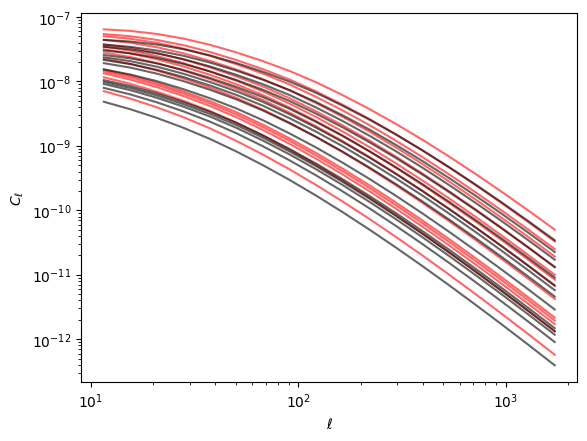

In [179]:
"""Plots: Test C(ell) function"""

ell_bin_number = 18

for j in range(int(len(D_testdata)/ell_bin_number) - 1):
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata_lin[j*ell_bin_number:(j+1)*ell_bin_number], "r", alpha= 0.6)
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], D_testdata_GR_lin[j*ell_bin_number:(j+1)*ell_bin_number], "k", alpha= 0.6)


plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xscale('log')
plt.yscale('log')
plt.show()

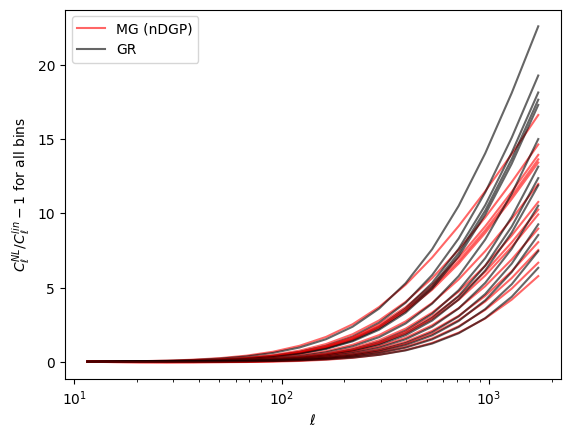

In [180]:
"""Plots: Test C(ell) difference (need mock as well)"""

ell_bin_number = 18

for j in range(int(len(D_testdata)/ell_bin_number) - 1):
    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], \
    D_testdata[j*ell_bin_number:(j+1)*ell_bin_number]/ D_testdata_lin[j*ell_bin_number:(j+1)*ell_bin_number] - 1, "r", alpha=0.6)

    plt.plot(ell_testdata[j*ell_bin_number:(j+1)*ell_bin_number], \
    D_testdata_GR[j*ell_bin_number:(j+1)*ell_bin_number]/ D_testdata_GR_lin[j*ell_bin_number:(j+1)*ell_bin_number] - 1, "k", alpha=0.6)


plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell^{NL}/ C_\ell^{lin} - 1$ for all bins')
plt.xscale('log')
plt.legend(["MG (nDGP)", "GR"])
plt.show()

# 4. Get quantities to put in MCMC step

## 4a. Get mock C(ell) data

In [181]:
"""Check we match SRD"""
def bins(ell_min, ell_max, ell_bin_num):

    # define quantities for binning in ell
    ell_binned_limits = np.linspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = 10**((bin_edge1 + bin_edge2) / 2)
    # Repeat ell_binned over all redshift bins, so that len(ell_binned)=len(C_ell_array)
    return ell_binned

# ell binning for shear
ells_SRD = np.loadtxt("/home/c2042999/PCA_project/ell-values")

print((np.log10(bins(20, 15000, 20)) - np.log10(ells_SRD)))


[ 4.50063231e-08 -3.87029562e-08  7.11952985e-09 -3.15261872e-08
  7.37764783e-09 -3.76473941e-08 -4.61608618e-09 -5.19314360e-08
 -4.20071742e-08  1.06302975e-08 -2.08344080e-08 -2.40778921e-08
 -1.60361210e-07 -1.75589898e-08  8.43039425e-08 -2.05472657e-08
  1.04437090e-08 -2.66744200e-08  1.98904773e-08  1.59989407e-07]


In [182]:
"""Get mock C(ell) data"""

# define ell and C_ell shapes -- will depend on the data

ell_min_mockdata = 20
ell_max_mockdata = 15000

# define quantities for binning of ell -- will depend on the data

ell_bin_num_mockdata = 20

# Define cosmology -- our "universe cosmology"

cosmo_universe = ccl.Cosmology(Omega_c = 0.26, 
                          Omega_b = 0.05, 
                          h = 0.7, 
                          n_s = 0.96,
                          A_s = 2.01e-9)


# find C_ell for non-linear matter power spectrum
mockdata = Cell_GR(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, \
                cosmo_universe, z , Binned_distribution, "non-linear", [1.0 , 1.0, 1.0])

ell_mockdata = mockdata[0]
D_mockdata = mockdata[1]
D_mockdata = (np.array(D_mockdata)).flatten()

# For plot below, compare with linear
data_lin_plot = Cell_GR(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, \
                cosmo_universe, z , Binned_distribution, "linear", [1.0 , 1.0, 1.0])
D_data_lin_plot = data_lin_plot[1]
D_data_lin_plot = (np.array(D_data_lin_plot)).flatten()

del mockdata, data_lin_plot



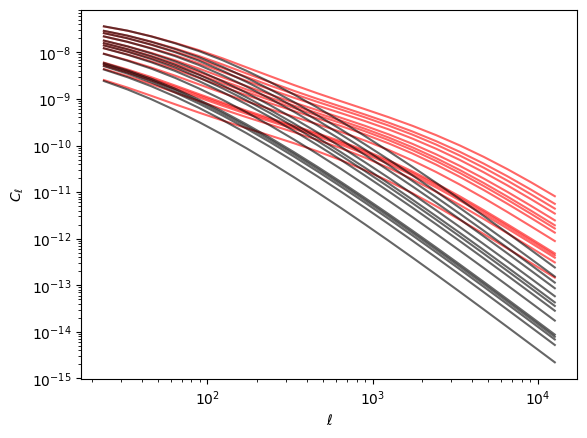

In [183]:
"""Plots: Test C(ell) function"""

ell_bin_number = int(len(ell_mockdata)/((len(Binned_distribution)+1)*len(Binned_distribution)/2))

for j in range(int(len(D_mockdata)/ell_bin_number) - 1):
    plt.plot(ell_mockdata[j*ell_bin_number:(j+1)*ell_bin_number], D_mockdata[j*ell_bin_number:(j+1)*ell_bin_number], "r", alpha=0.6)
    plt.plot(ell_mockdata[j*ell_bin_number:(j+1)*ell_bin_number], D_data_lin_plot[j*ell_bin_number:(j+1)*ell_bin_number], "k", alpha=0.6)
    #plt.plot(ell_mockdata[j*ell_bin_number:(j+1)*ell_bin_number], (D_mockdata[j*ell_bin_number:(j+1)*ell_bin_number] - D_data_lin_plot[j*ell_bin_number:(j+1)*ell_bin_number])/D_mockdata[j*ell_bin_number:(j+1)*ell_bin_number], "k", alpha=0.6)


plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xscale('log')
plt.yscale('log')
plt.show()

## 4b. Get covariance matrix

Note that for Y1 SRD gives area = 12.3 k deg^2 (total area on sphere = 41.253 k deg^2), so f_sky = 0.298.

Also, they define the number density following empirical results from the HSC survey (Appendix F1), finding a value of 18 arcmin^{−2} for Y1.

Also, For Y1, the per-bin bias values that were actually used were [1.562362, 1.732963, 1.913252, 2.100644, 2.293210].

Also, for Y1, neff = 11.112 over the 5 bins, so 2.2224 per bin

In [207]:
"""Define sacc file - Cl^{ij}(ell) for some ell bins and redshift bins"""
# My redshifts (for now)
src0 = Binned_distribution[0]
src1 = Binned_distribution[1]
src2 = Binned_distribution[2]
src3 = Binned_distribution[3]
src4 = Binned_distribution[4]
z_src = z

ell_bins = ell_mockdata[:ell_bin_number]

# z binning 

src_bins = [src0, src1, src2, src3, src4]

s = sacc.Sacc()

for i, bin1 in enumerate(src_bins):
    for j, bin2 in enumerate(src_bins):
        if j >= i:
            s.add_tracer('NZ', 'src%d'%i, z=z_src, nz=bin1)
            # construct Cl_gM for sacc file
            shearA = ccl.WeakLensingTracer(cosmo_universe, dndz=(z_src, bin1), has_shear=True)
            shearB = ccl.WeakLensingTracer(cosmo_universe, dndz=(z_src, bin2), has_shear=True)
    
            Cl = ccl.angular_cl(cosmo_universe, shearA, shearB, ell_bins) 
            # bin ell
    
            s.add_ell_cl('galaxy_shear_cl_ee', 'src%d'%i, 
                                'src%d'%j, ell_bins, Cl, tracers_later=True)

s.save_fits('/home/c2042999/PCA_project/Covariance_understanding/SRD_specs/cl_and_xi_data.fits', overwrite=True)

In [208]:
s = sacc.Sacc.load_fits("/home/c2042999/PCA_project/Covariance_understanding/SRD_specs/cl_and_xi_data.fits")

In [212]:
config = '/home/c2042999/PCA_project/Covariance_understanding/SRD_specs/Fourier_cosmic_shear_gauss.yaml'

gauss_calc = CovarianceCalculator(config)

# get matrix
gauss_cov = gauss_calc.get_covariance()

Computing independent covariance blocks
Rank None: ('src0', 'src0'), ('src0', 'src0')
Rank None: ('src0', 'src0'), ('src0', 'src1')
Rank None: ('src0', 'src0'), ('src0', 'src2')
Rank None: ('src0', 'src0'), ('src0', 'src3')
Rank None: ('src0', 'src0'), ('src0', 'src4')
Rank None: ('src0', 'src0'), ('src1', 'src1')
Rank None: ('src0', 'src0'), ('src1', 'src2')
Rank None: ('src0', 'src0'), ('src1', 'src3')
Rank None: ('src0', 'src0'), ('src1', 'src4')
Rank None: ('src0', 'src0'), ('src2', 'src2')
Rank None: ('src0', 'src0'), ('src2', 'src3')
Rank None: ('src0', 'src0'), ('src2', 'src4')
Rank None: ('src0', 'src0'), ('src3', 'src3')
Rank None: ('src0', 'src0'), ('src3', 'src4')
Rank None: ('src0', 'src0'), ('src4', 'src4')
Rank None: ('src0', 'src1'), ('src0', 'src1')
Rank None: ('src0', 'src1'), ('src0', 'src2')
Rank None: ('src0', 'src1'), ('src0', 'src3')
Rank None: ('src0', 'src1'), ('src0', 'src4')
Rank None: ('src0', 'src1'), ('src1', 'src1')
Rank None: ('src0', 'src1'), ('src1', 's

(300, 300)


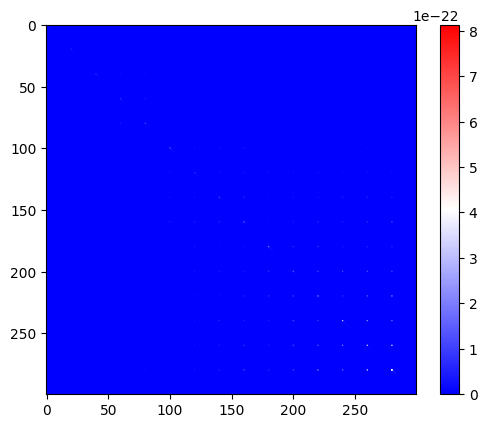

In [214]:
print(gauss_cov.shape)
plt.imshow(gauss_cov, origin='upper',  cmap='bwr')
plt.colorbar()
plt.show()

In [215]:
def cov2corr(cov):
    """
    Convert a covariance matrix into a correlation matrix
    input:
        cov: numpy.array with dim:(N,N)
    returns:
        corr: numpy.array with dim:(N,N)
    """
    sig = np.sqrt(cov.diagonal())
    return cov/np.outer(sig, sig)

(300, 300)


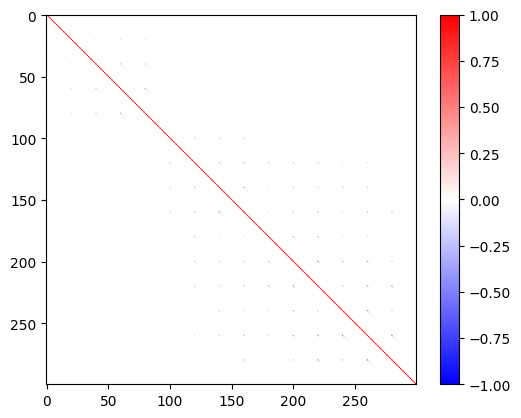

In [216]:
corr = cov2corr(gauss_cov)
print(corr.shape)
plt.imshow(corr, origin='upper', vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()
plt.show()

In [217]:
"""Get SRD covariance matrix to compare"""

# covariance for shear bin combinations, in order: z11, z12, z13,..., z15, z22, z23,...z55
shear_cl_SRD = np.loadtxt("/home/c2042999/PCA_project/cov_shearonly_Gaussian_Y1.txt")

print(shear_cl_SRD.shape)

(300, 300)


(300, 300)


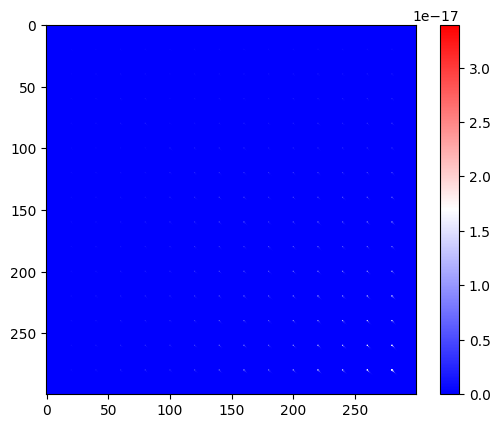

In [218]:
print(shear_cl_SRD.shape)
plt.imshow(shear_cl_SRD, origin='upper',  cmap='bwr')
plt.colorbar()
plt.show()

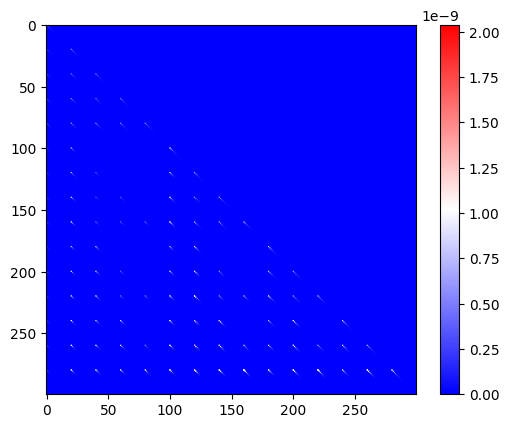

In [219]:
"""Get cholensky decomposition"""

L_choleski = np.linalg.cholesky(np.matrix(shear_cl_SRD))
L_choleski_inv = np.linalg.inv(L_choleski)
plt.imshow(L_choleski, origin='upper',  cmap='bwr')
plt.colorbar()
plt.show()

(300, 300)


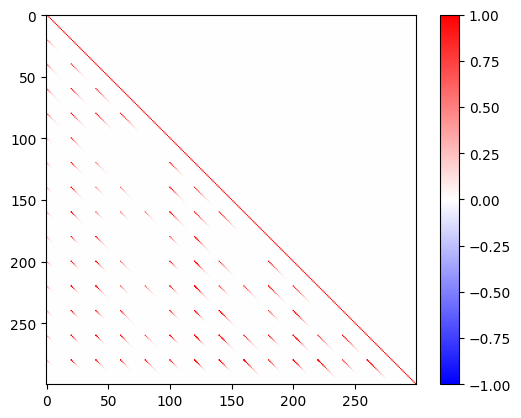

In [220]:
corr_ch = cov2corr(L_choleski)
print(corr_ch.shape)
plt.imshow(corr_ch, origin='upper', vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()
plt.show()

## 4c. Get noise for C_ells

In [42]:
np.random.seed(22)
D_mockdata_noise = np.random.multivariate_normal(D_mockdata, gauss_cov)

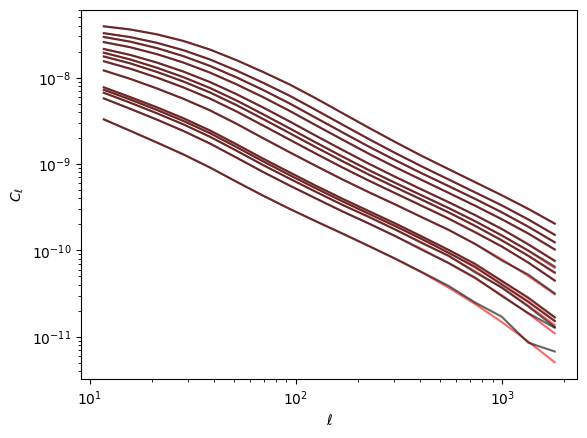

In [43]:
"""Plots: Test noisy C(ell) function"""

ell_bin_number = int(len(ell_mockdata)/((len(Binned_distribution)+1)*len(Binned_distribution)/2))

for j in range(int(len(D_mockdata)/ell_bin_number) - 1):
    plt.plot(ell_mockdata[j*ell_bin_number:(j+1)*ell_bin_number], D_mockdata[j*ell_bin_number:(j+1)*ell_bin_number], "r", alpha=0.6)
    plt.plot(ell_mockdata[j*ell_bin_number:(j+1)*ell_bin_number], D_mockdata_noise[j*ell_bin_number:(j+1)*ell_bin_number], "k", alpha=0.6)
    #plt.plot(ell_mockdata[j*ell_bin_number:(j+1)*ell_bin_number], D_mockdata[j*ell_bin_number:(j+1)*ell_bin_number]-D_mockdata_noise[j*ell_bin_number:(j+1)*ell_bin_number])


plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xscale('log')
plt.yscale('log')
plt.show()

## 4d. Package data

In [221]:
# WITHOUT NOISE
C_ell_data_mock = [D_mockdata, ell_mockdata, z, Binned_distribution, ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata]

# WITH NOISE
#C_ell_data_mock = [D_mockdata_noise, ell_mockdata, z, Binned_distribution, ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata]




# 5. Finding PCA components

PCA conventions in Python

A = $\begin{bmatrix}
a00 & a01 & a02\\
a10 & a11 & a12
\end{bmatrix}$ = [[a00, a01, a02], [a10, a11, a12]], with aij = A[i][j]

A[0] is first row, A[:][0] is first column

len(A) = number of rows, len(A[0]) = number of columns

AxB = np.matmul(A,B)

for B = $\begin{bmatrix}
b00 & b01 & b02\\
b10 & b11 & b12
\end{bmatrix}$, np.append(A,B, axis = 0) = A = $\begin{bmatrix}
a00 & a01 & a02\\
a10 & a11 & a12\\
b00 & b01 & b02\\
b10 & b11 & b12
\end{bmatrix}$ 

In [222]:
# Perform PCA with numpy.linalg.svd - find rotation matrix
def findPCA(M_data, B_data, L_ch_inv):
    Delta = np.array(np.matmul(L_ch_inv, (B_data - M_data).T).T)
    Usvd, s, vh = np.linalg.svd(Delta.T, full_matrices=True)
    Usvd = Usvd.T
    return Usvd

## 5 a. tests

In [225]:
"""Package quanitites to imput into likelihood function"""

"""Define MCMC step"""
cosmo_MCMC = ccl.Cosmology(Omega_c = 0.26, 
                          Omega_b = 0.05, 
                          h = 0.7, 
                          n_s = 0.96,
                          A_s = 2.01e-9)
MGParams = [0.2,1.0,1.0]

In [210]:
#TEST: Write out the difference matrix

"""MG"""
# find C_ell for non-linear matter power spectrum
data1 = Cell(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, \
                cosmo_MCMC, z , Binned_distribution, P_k_NL_nDGP, MGParams)

ell = data1[0]
B1 = data1[1]
B1 = (np.array(B1)).flatten()

data1_lin = Cell(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, \
                cosmo_MCMC, z , Binned_distribution, P_k_nDGP_lin, MGParams)

M1 = data1_lin[1]
M1 = (np.array(M1)).flatten()


"""GR"""
# find C_ell for non-linear matter power spectrum
data2 = Cell_GR(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, \
                cosmo_MCMC, z , Binned_distribution, "non-linear", MGParams)

B2 = data2[1]
B2 = (np.array(B2)).flatten()

data2_lin = Cell_GR(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, \
                cosmo_MCMC, z , Binned_distribution, "linear", MGParams)

M2 = data2_lin[1]
M2 = (np.array(M2)).flatten()

del data1, data1_lin, data2, data2_lin

B_data =np.array([B1,B2])
M_data =np.array([M1,M2])



In [50]:
Delta = np.array(np.matmul(L_choleski_inv,(B_data - M_data).T).T)

print("Size of difference matrix Delta = ", Delta.shape)
print((B_data - M_data).shape)

Size of difference matrix Delta =  (2, 270)
(2, 270)


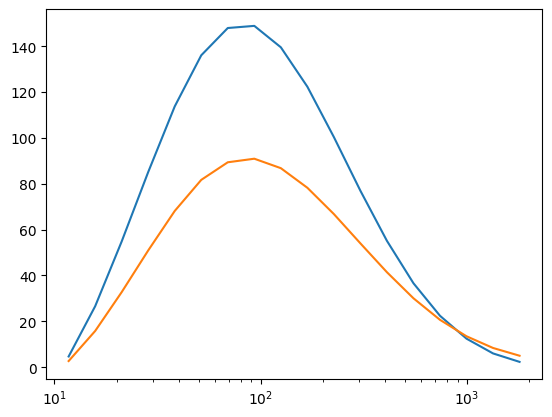

In [51]:
#TEST

Delta_centered = np.zeros((len(Delta),len(Delta[0])))
for i in range(len(Delta[0])):
    offset = np.mean(Delta.T[i])
    Delta_centered[:,i] = Delta[:,i] - offset


plt.xscale('log')
#plt.ylim(0,0.5)
for i in range(len(B_data)):
    plt.plot(ell[0:ell_bin_number],Delta[i][0:ell_bin_number])

In [52]:
#TEST: Perform PCA with sklearn (Choose n_components to keep)
pca = PCA()

# Apply sklearn PCA method
sklearn_PCA = pca.fit(Delta)

# Find vectors in direction of PCs (normalized ,positive)
PCAs_vects_sklearn = sklearn_PCA.components_
print("PCA eigenvector array size = ", PCAs_vects_sklearn.shape)

# Find eigenvalues for each PC
PCAs_eigenvals_sklearn = sklearn_PCA.singular_values_

print("eigenvalues = ", PCAs_eigenvals_sklearn)
#find PC vectors with eigenvalues as norm

Usklearn = np.matmul(np.diag(PCAs_eigenvals_sklearn), np.matrix(PCAs_vects_sklearn))

print("PCA norm eigenvector array size = ",Usklearn.shape)

PCA eigenvector array size =  (2, 270)
eigenvalues =  [4.80644689e+02 3.41091820e-13]
PCA norm eigenvector array size =  (2, 270)


In [53]:
#TEST: Perform PCA with numpy.linalg.svd

Usvd, s, vh = np.linalg.svd(Delta.T, full_matrices=True)

Usvd = Usvd.T

print("eigenvalues = ", s)

print("shape U = ", Usvd.shape)
print("shape sigma = ", s.shape)
print("shape V_transpose = ", vh.shape)

eigenvalues =  [1992.68333373  211.47605735]
shape U =  (270, 270)
shape sigma =  (2,)
shape V_transpose =  (2, 2)


In [54]:
def findU_PCAmethod(Delta):
    
    # find eigenvectors and eigenvalues of AAt = Delta*Deltat
    AAt = np.matmul(Delta,np.transpose(Delta))
    eigenvals,eigenvects = np.linalg.eig(AAt)

    eigenvals = eigenvals.real
    eigenvects = eigenvects.real

    # Put eigenvectors and eigenvalues in right order, find U
    #composedmatrix = np.array(np.append([eigenvals],np.transpose(eigenvects), axis = 0))
    #orderedmatrix = composedmatrix[:, (-composedmatrix)[0].argsort()]
    #U = np.transpose(orderedmatrix[1:])
    return eigenvects, eigenvals

In [55]:
""" PCA decomposition"""

# Find Delta as 990 rows and 9 columns
manual_soln = findU_PCAmethod(np.transpose(Delta))
Umanual = manual_soln[0].T
eigenval_manual = manual_soln[1]
print("eigenvalues = ", eigenval_manual[:8]**0.5)


eigenvalues =  [1.99268333e+03 2.11476057e+02            nan            nan
 1.21359393e-05 1.21359393e-05            nan 1.47825604e-05]


/tmp/ipykernel_2120021/3623146480.py:7: RuntimeWarning: invalid value encountered in sqrt
  print("eigenvalues = ", eigenval_manual[:8]**0.5)


In [56]:
print("full eigenvalues = ", np.diag(eigenval_manual)**0.5)

full eigenvalues =  [[1.99268333e+03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.11476057e+02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00            nan ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.32630132e-09
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
             nan 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00            nan]]


/tmp/ipykernel_2120021/4117662826.py:1: RuntimeWarning: invalid value encountered in sqrt
  print("full eigenvalues = ", np.diag(eigenval_manual)**0.5)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


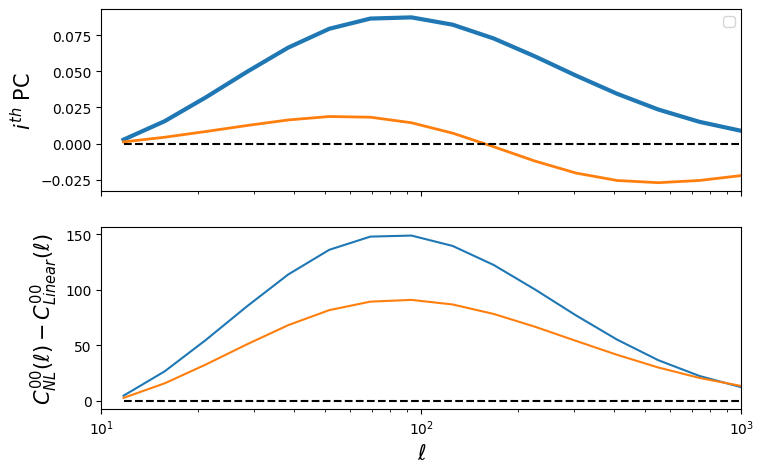

In [58]:
"""Plot PCA components for different methods as a function of ell, and compare with angular power spectra"""

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False,figsize=(8, 5))

for i in range(2):
    #ax1.plot(ell[0:ell_bin_num], Umanual[i][0:ell_bin_num], color = "b", label = "Manual method")
    ax1.plot(ell[0:ell_bin_number], -Usvd[i][0: ell_bin_number], linewidth=3 - i)
    #ax1.plot(ell[0:ell_bin_num], Usklearn[i,0:ell_bin_num], label = "sklearn method", color = "y")
    #ax1.plot(ell[0:ell_bin_number], PCAs_vects_sklearn[i,0:ell_bin_number], color = "y",linewidth=2+i/2)
    
ax1.plot(ell[0:ell_bin_number], np.zeros(len(ell[0:ell_bin_number])), "k--")

#line2, = ax1.plot(ell[0:ell_bin_number], PCAs_vects_sklearn[0,0:ell_bin_number], label = "centered around zero", color = "y")
#line1, = ax1.plot(ell[0:ell_bin_number], -Usvd[0][0: ell_bin_number], color = "r" , label = "not centered", linewidth=2)
ax1.legend()

#line1.remove()
#line2.remove()

ax1.set_ylabel(r'$i^{th}$ PC', size = 15)
plt.xscale("log")


#plt.ylim(0,0.5)
for i in range(len(B_data)):
    ax2.plot(ell[0:ell_bin_number],Delta[i][0:ell_bin_number])
ax2.plot(ell[0:ell_bin_number], np.zeros(len(ell[0:ell_bin_number])), "k--")

ax2.set_ylabel(r'$C^{00}_{NL}(\ell) - C^{00}_{Linear}(\ell)$', size = 15)
ax2.set_xlabel(r'$\ell$', size = 15)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.2)
ax1.set_xlim(10,1e3)


#plt.savefig('PCcompare.pdf' , bbox_inches='tight')
plt.show()



# 6. Likelihood function

In [223]:
# log likelihood - no scale cuts
def loglikelihood_nocut(Data, cosmoMCMCStep, mu0, MGparams, Covmat):
    #start = time.time()

    # Extract real data vector
    D_data, ell_mockdata, z, Binned_distribution, ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata = Data
    
    # Get theoretical data vector for single MCMC step
    D_theory = (np.array(Cell_linear(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata,cosmoMCMCStep,\
                 z , Binned_distribution, P_k_musigma, mu0)[1])).flatten()
    
    Diff = (D_data - D_theory)
    
    #print("time = ", time.time() - start)

    return -0.5*(np.matmul(np.matmul(Diff,np.linalg.inv(Covmat)),Diff))

# log likelihood - no scale cuts
def loglikelihood_nocut_variableL(Data, cosmoMCMCStep, mu0, MGparams, Covmat):
    #start = time.time()

    # Extract real data vector
    D_data, ell_mockdata, z, Binned_distribution, ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata = Data
    
    # Get theoretical data vector for single MCMC step
    D_theory = (np.array(Cell_linear(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata,cosmoMCMCStep,\
                 z , Binned_distribution, P_k_musigma, mu0)[1])).flatten()
    
    Diff = (D_data - D_theory)[16:]

    Covmat_cut = Covmat[16:,16:]
    
    #print("time = ", time.time() - start)

    return -0.5*(np.matmul(np.matmul(Diff,np.linalg.inv(Covmat_cut)),Diff))

# log likelihood with cut data
# P_k_sim = P_k_sim_mock
# Data = C_ell_data_mock
# Covmat = gauss_cov
def loglikelihood(Data, cosmoMCMCstep, mu0, MGparams, L_ch, L_ch_inv):
    
    #start = time.time()

    # Extract real data vector
    D_data, ell_mockdata, z, Binned_distribution, ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata = Data
    
    # Get theoretical data vector for single MCMC step
    D_theory = (np.array(Cell_linear(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata,cosmoMCMCstep,\
                 z , Binned_distribution, P_k_musigma, mu0)[1])).flatten()
    
    # Find difference
    Diff = (D_data - D_theory)
    # Find Choleski scaled data vector
    Diff_ch = np.array(np.matmul(L_ch_inv, Diff.T))[0]

    # GET DATA FOR DIFFERENCE MATRIX
    """MG1: nDGP"""
    # find C_ell for non-linear matter power spectrum
    data1 = Cell(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, \
                    cosmoMCMCstep, z , Binned_distribution, P_k_NL_nDGP, MGparams)
    
    ell = data1[0]
    B1 = data1[1]
    B1 = (np.array(B1)).flatten()
       
    # find C_ell for linear matter power spectrum
    data1_lin = Cell(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, \
                    cosmoMCMCstep, z , Binned_distribution, P_k_nDGP_lin, MGparams)
    
    M1 = data1_lin[1]
    M1 = (np.array(M1)).flatten()
    
    """GR"""
    # find C_ell for non-linear matter power spectrum
    data2 = Cell_GR(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, \
                    cosmoMCMCstep, z , Binned_distribution, "non-linear", MGparams)
    
    B2 = data2[1]
    B2 = (np.array(B2)).flatten()

    # find C_ell for linear matter power spectrum    
    data2_lin = Cell_GR(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, \
                    cosmoMCMCstep, z , Binned_distribution, "linear", MGparams)

    
    M2 = data2_lin[1]
    M2 = (np.array(M2)).flatten()
    
    B_data =np.array([B1,B2])
    M_data =np.array([M1,M2])

    # EXTRACT PCA MATRIX
    Usvd = findPCA(M_data, B_data, L_ch_inv)

    # Cut data vector (choleski cov. matrix = I)
    Diff_cut = np.matmul(Usvd[len(M_data):], Diff_ch.T)
    
    #print("time = ", time.time() - start)

    return -0.5*(np.matmul(Diff_cut.T,Diff_cut))

In [226]:
print(loglikelihood_nocut(C_ell_data_mock, cosmo_MCMC, 0.0, MGParams, shear_cl_SRD))

-41239.519054903154


In [80]:
print(loglikelihood(C_ell_data_mock, cosmo_MCMC, 1.1, MGParams, L_choleski, L_choleski_inv))

-560265.7945655097


In [227]:
print(loglikelihood(C_ell_data_mock, cosmo_MCMC, 0.0, MGParams, L_choleski, L_choleski_inv))

-9.376162782284107


In [82]:
print(loglikelihood(C_ell_data_mock, cosmo_MCMC, 1.0, MGParams, L_choleski, L_choleski_inv))

-430971.1686881638


# 7. Run the MCMC

In [135]:
def log_likelihood(theta, Data, MGparams, Covmat):
    Omega_c, mu0 = theta # h, sigma_8, n_s
    h = cosmo_universe["h"]
    A_s = cosmo_universe["A_s"]
    n_s = cosmo_universe["n_s"]
    cosmoMCMCstep = ccl.Cosmology(Omega_c = Omega_c, 
                      Omega_b = 0.05,
                      h = h,
                      n_s = n_s,
                      A_s = A_s)
    return loglikelihood(Data, cosmoMCMCstep, mu0, MGparams, Covmat)

In [147]:
def log_prior(theta):
    Omega_c, mu0 = theta
    if 0.23 < Omega_c < 0.31 and -0.5 < mu0 < 0.5: #and 0.5 < h < 0.9 and 0.5 < sigma_8 < 1.5 and 0.6 < n_s < 1.4:
        return 0.0
    return -np.inf

In [138]:
def log_probability(theta, Data, MGparams, Covmat):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, Data, MGparams, Covmat)

In [ ]:
#MCMC method

# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
#and then run 10,000 steps of MCMC
Omega_c_est = 0.28
h_est = 0.7
sigma_8_est = 0.7
n_s_est = 0.9
mu0_est = 0.1

pos = [Omega_c_est, mu0_est] + 1e-2 * np.random.randn(15, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(C_ell_data_mock, MGParams, gauss_cov)
)

sampler.run_mcmc(pos, 300, progress=True);

In [93]:
flat_samples = sampler.get_chain(discard=55, flat=True)
labels = ["Omega_c", "h", "sigma_8"]
print(flat_samples.shape)

figure = corner.corner(
    flat_samples, labels=labels
);

ndim = 2

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

value1 = [cosmo_universe["Omega_c"], cosmo_universe["h"],cosmo_universe["sigma8"]]

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axhline(value1[yi], color="g")


NameError: name 'sampler' is not defined

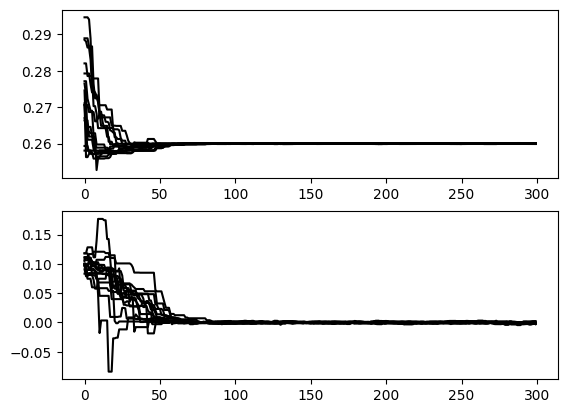

In [157]:
samples_chain = sampler.chain

fig, ax = plt.subplots(2)

for i in range(len(samples_chain)):
    ax[0].plot(samples_chain[i, :, 0], color = "black")
    #ax[0].plot([0,500],[value1[0],value1[0]], color="gray", linestyle="--")
    ax[1].plot(samples_chain[i, :, 1], color = "black")
    #ax[1].plot([0,500],[value1[1],value1[1]], color="gray", linestyle="--")
    #ax[2].plot(samples_chain[i, :, 2], color = "black")
    #ax[2].plot([0,500],[value1[2],value1[2]], color="gray", linestyle="--")
    #ax[3].plot(samples_chain[i, :, 3], color = "black")
    #ax[3].plot([0,500],[value1[3],value1[3]], color="gray", linestyle="--")


# 8. Run the MCMC - compare different methods

## 8a. run with PCA method as scale cuts

In [228]:
def log_likelihood(theta, Data, MGparams, L_ch, L_ch_inv):
    Omega_c, mu0 = theta # h, sigma_8, n_s
    h = cosmo_universe["h"]
    A_s = cosmo_universe["A_s"]
    n_s = cosmo_universe["n_s"]
    cosmoMCMCstep = ccl.Cosmology(Omega_c = Omega_c, 
                      Omega_b = 0.05,
                      h = h,
                      n_s = n_s,
                      A_s = A_s)
    return loglikelihood(Data, cosmoMCMCstep, mu0, MGparams,  L_ch, L_ch_inv)

In [229]:
def log_prior(theta):
    Omega_c, mu0 = theta
    if 0.23 < Omega_c < 0.31 and -0.5 < mu0 < 0.5: #and 0.5 < h < 0.9 and 0.5 < sigma_8 < 1.5 and 0.6 < n_s < 1.4:
        return 0.0
    return -np.inf

In [230]:
def log_probability(theta, Data, MGparams,  L_ch, L_ch_inv):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, Data, MGparams,  L_ch, L_ch_inv)

In [ ]:
#MCMC method

# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
#and then run 10,000 steps of MCMC
Omega_c_est = 0.28
#h_est = 0.7
#sigma_8_est = 0.7
#n_s_est = 0.9
mu0_est = 0.1

pos = [Omega_c_est, mu0_est] + 1e-2 * np.random.randn(15, 2)
nwalkers, ndim = pos.shape

sampler_PCA = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(C_ell_data_mock, MGParams, L_choleski, L_choleski_inv)
)

sampler_PCA.run_mcmc(pos, 400, progress=True);

 48%|███████████████████████████████████████████████████████████████████████████████                                                                                    | 194/400 [57:17<1:01:19, 17.86s/it]

In [232]:
# Save chains

print(sampler_PCA.chain.shape)
np.save("chains/sample_PCA.npy", sampler_PCA.chain)

(15, 400, 2)


In [233]:
sampler_PCA_arr = np.load("chains/sample_PCA.npy")

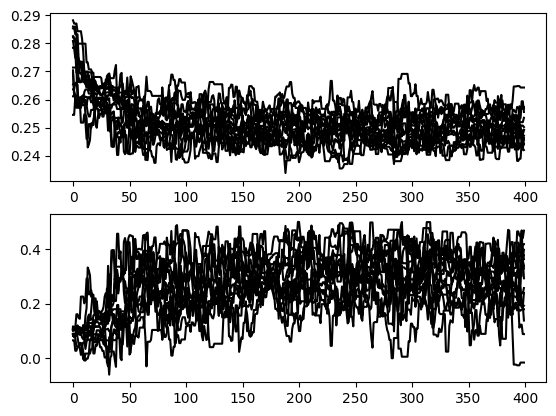

In [234]:
fig, ax = plt.subplots(2)

for i in range(len(sampler_PCA_arr)):
    ax[0].plot(sampler_PCA_arr[i, :, 0], color = "black")
    #ax[0].plot([0,500],[value1[0],value1[0]], color="gray", linestyle="--")
    ax[1].plot(sampler_PCA_arr[i, :, 1], color = "black")
    #ax[1].plot([0,500],[value1[1],value1[1]], color="gray", linestyle="--")
    #ax[2].plot(samples_chain[i, :, 2], color = "black")
    #ax[2].plot([0,500],[value1[2],value1[2]], color="gray", linestyle="--")
    #ax[3].plot(samples_chain[i, :, 3], color = "black")
    #ax[3].plot([0,500],[value1[3],value1[3]], color="gray", linestyle="--")


(4950, 2)


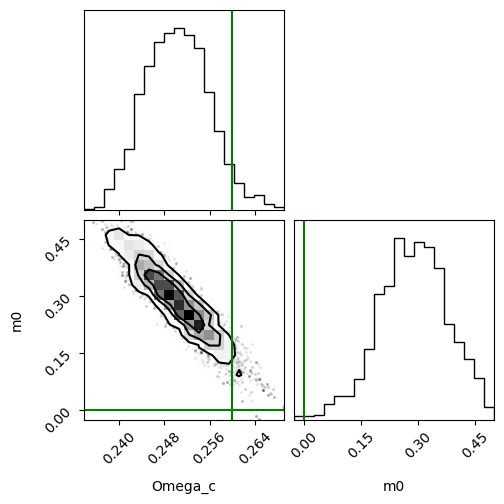

In [235]:
burnin = 70
final_length = len(sampler_PCA_arr)*(len(sampler_PCA_arr[0])-burnin)

flat_samples = sampler_PCA_arr[:,burnin:].reshape(final_length,2)
labels = ["Omega_c", "m0"]
print(flat_samples.shape)

figure = corner.corner(
    flat_samples, labels=labels
);

ndim = 2

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

value1 = [cosmo_universe["Omega_c"], 0.0]

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axhline(value1[yi], color="g")


In [236]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## 8b. Run with no scale cuts

In [237]:
def log_likelihood(theta, Data, MGparams, Covmat):
    Omega_c, mu0 = theta # h, sigma_8, n_s
    h = cosmo_universe["h"]
    A_s = cosmo_universe["A_s"]
    n_s = cosmo_universe["n_s"]
    cosmoMCMCStep = ccl.Cosmology(Omega_c = Omega_c, 
                      Omega_b = 0.05,
                      h = h,
                      n_s = n_s,
                      A_s = A_s)
    return loglikelihood_nocut(Data, cosmoMCMCStep, mu0, MGparams, Covmat)

In [238]:
def log_prior(theta):
    Omega_c, mu0 = theta
    if 0.0 < Omega_c < 1.0 and -5 < mu0 < 5: #and 0.5 < h < 0.9 and 0.5 < sigma_8 < 1.5 and 0.6 < n_s < 1.4:
        return 0.0
    return -np.inf

In [239]:
def log_probability(theta, Data, MGparams, Covmat):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, Data, MGparams, Covmat)

In [ ]:
#MCMC method

# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
#and then run 10,000 steps of MCMC
Omega_c_est = 0.28
#h_est = 0.7
#sigma_8_est = 0.7
#n_s_est = 0.9
mu0_est = 0.1

pos = [Omega_c_est, mu0_est] + 1e-2 * np.random.randn(15, 2)
nwalkers, ndim = pos.shape

sampler_nocut = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(C_ell_data_mock, MGParams, shear_cl_SRD)
)

sampler_nocut.run_mcmc(pos, 400, progress=True);

  0%|▍                                                                                                                                                                      | 1/400 [00:08<55:34,  8.36s/it]

In [ ]:
# Save chains

print(sampler_nocut.chain.shape)
np.save("chains/sample_nocut.npy", sampler_nocut.chain)

In [256]:
sampler_nocut_arr = np.load("chains/sample_nocut.npy")

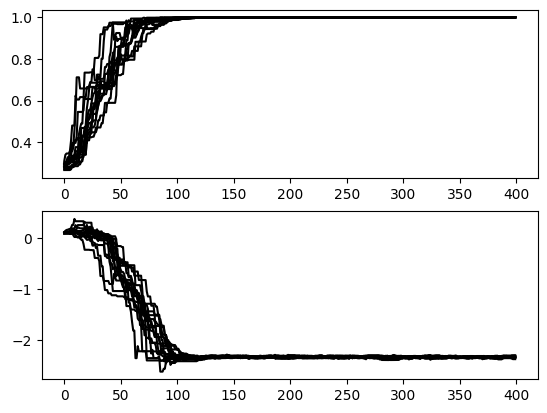

In [257]:
fig, ax = plt.subplots(2)

for i in range(len(sampler_nocut_arr)):
    ax[0].plot(sampler_nocut_arr[i, :, 0], color = "black")
    #ax[0].plot([0,500],[value1[0],value1[0]], color="gray", linestyle="--")
    ax[1].plot(sampler_nocut_arr[i, :, 1], color = "black")
    #ax[1].plot([0,500],[value1[1],value1[1]], color="gray", linestyle="--")
    #ax[2].plot(samples_chain[i, :, 2], color = "black")
    #ax[2].plot([0,500],[value1[2],value1[2]], color="gray", linestyle="--")
    #ax[3].plot(samples_chain[i, :, 3], color = "black")
    #ax[3].plot([0,500],[value1[3],value1[3]], color="gray", linestyle="--")


(4050, 2)


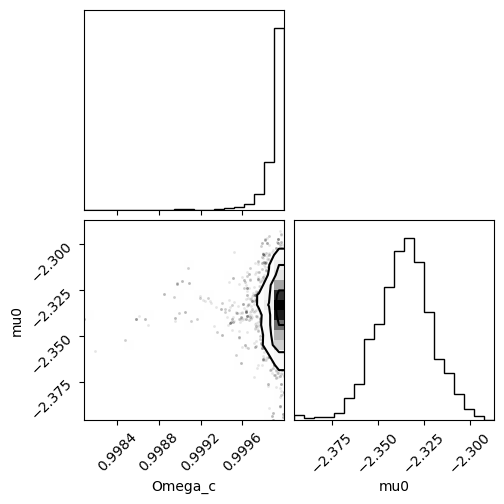

In [258]:
burnin = 130
final_length = len(sampler_nocut_arr)*(len(sampler_nocut_arr[0])-burnin)

flat_samples = sampler_nocut_arr[:,burnin:].reshape(final_length,2)
labels = ["Omega_c", "mu0"]
print(flat_samples.shape)

figure = corner.corner(
    flat_samples, labels=labels
);


ndim = 2

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

value1 = [cosmo_universe["Omega_c"], 0.0]

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axhline(value1[yi], color="g")

#ax.set_xlim(0.259,0.285)
#ax.set_ylim(-0.5,0.01)

In [259]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## 8c. run with naive scale cuts

### Get data for scale cuts

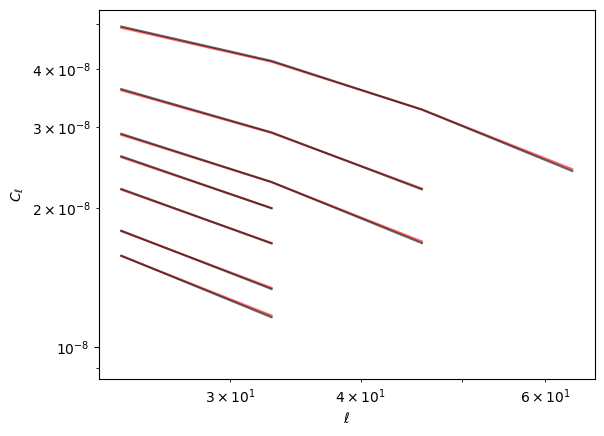

In [260]:
"""Get new Mock data with cuts in ell - ideal case, not implemented"""

for j in range(int(len(D_mockdata)/ell_bin_number)):
    for i in range(ell_bin_number):
        if (D_mockdata[j*ell_bin_number + i] - D_data_lin_plot[j*ell_bin_number + i])/D_mockdata[j*ell_bin_number + i] >= 0.01:
            plt.plot(ell_mockdata[j*ell_bin_number:(j)*ell_bin_number + i], D_mockdata[j*ell_bin_number:(j)*ell_bin_number + i], "r", alpha=0.6)
            plt.plot(ell_mockdata[j*ell_bin_number:(j)*ell_bin_number + i], D_data_lin_plot[j*ell_bin_number:(j)*ell_bin_number + i], "k", alpha=0.6)
            break

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xscale('log')
plt.yscale('log')
plt.show()

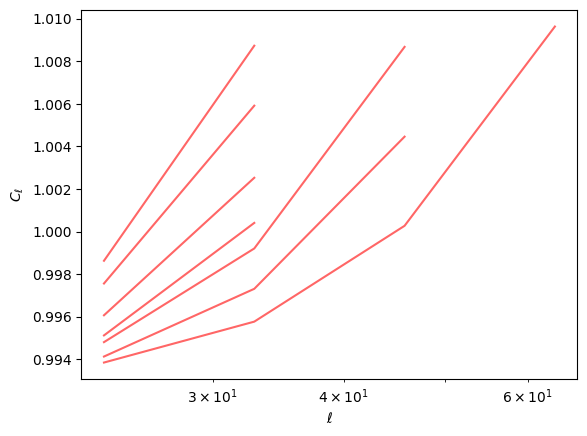

In [261]:
"""Get new Mock data with cuts in ell - ideal case, not implemented"""

for j in range(int(len(D_mockdata)/ell_bin_number)):
    for i in range(ell_bin_number):
        if (D_mockdata[j*ell_bin_number + i] - D_data_lin_plot[j*ell_bin_number + i])/D_mockdata[j*ell_bin_number + i] >= 0.01:
            plt.plot(ell_mockdata[j*ell_bin_number:(j)*ell_bin_number + i], D_mockdata[j*ell_bin_number:(j)*ell_bin_number + i]/D_data_lin_plot[j*ell_bin_number:(j)*ell_bin_number + i], "r", alpha=0.6)
            break

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xscale('log')
#plt.yscale('log')
plt.show()

In [274]:
"""Get new Mock data with cuts in ell - cut out everything but the first six bins"""

D_mockdata_cut = D_mockdata.copy() 
ell_mockdata_cut = ell_mockdata.copy()
gauss_cov_cut = shear_cl_SRD.copy()

n_cut = 2

for j in range(int(len(D_mockdata)/ell_bin_number)):
    #for i in range(12):
        #plt.scatter(ell_mockdata[j*ell_bin_number + n_cut + i], D_mockdata[j*ell_bin_number + n_cut + i], color="r", alpha=0.6)
        #plt.scatter(ell_mockdata[j*ell_bin_number + n_cut + i], D_data_lin_plot[j*ell_bin_number + n_cut + i], color="k", alpha=0.6)

    D_mockdata_cut = np.delete(D_mockdata_cut, np.arange(j*n_cut + n_cut,j*n_cut + 20), 0)
    ell_mockdata_cut = np.delete(ell_mockdata_cut, np.arange(j*n_cut + n_cut , j*n_cut + 20), 0)
    gauss_cov_cut = np.delete(gauss_cov_cut, np.arange(j*n_cut + n_cut , j*n_cut + 20), 0)
    gauss_cov_cut = np.delete(gauss_cov_cut, np.arange(j*n_cut + n_cut , j*n_cut + 20), 1)
'''   
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xscale('log')
plt.yscale('log')
plt.show()
'''

"   \nplt.xlabel(r'$\\ell$')\nplt.ylabel(r'$C_\\ell$')\nplt.xscale('log')\nplt.yscale('log')\nplt.show()\n"

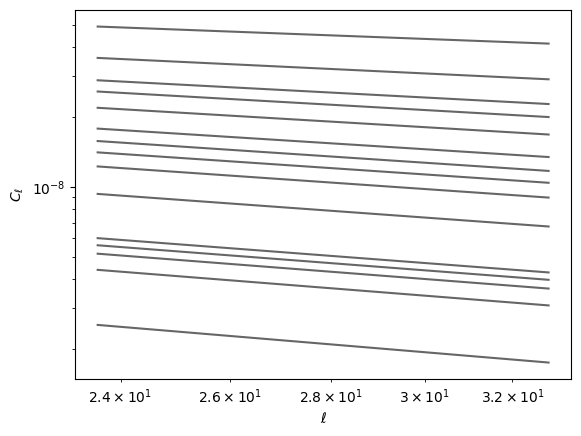

In [275]:
for j in range(int(len(D_mockdata)/ell_bin_number)):
    plt.plot(ell_mockdata_cut[j*n_cut:(j+1)*n_cut], D_mockdata_cut[j*n_cut:(j+1)*n_cut], "k", alpha=0.6)
    
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
print(gauss_cov_cut.shape)
plt.imshow(gauss_cov_cut, origin='upper',  cmap='bwr')
plt.colorbar()
plt.show()

In [ ]:
C_ell_data_mock_cut = [D_mockdata_cut, ell_mockdata_cut, z, Binned_distribution, ell_min_mockdata, ell_mockdata_cut[-1], n_cut]

### Run MCMC

In [ ]:
def log_likelihood(theta, Data, MGparams, Covmat):
    Omega_c, mu0 = theta # h, sigma_8, n_s
    h = cosmo_universe["h"]
    A_s = cosmo_universe["A_s"]
    n_s = cosmo_universe["n_s"]
    cosmoMCMCstep = ccl.Cosmology(Omega_c = Omega_c, 
                      Omega_b = 0.05,
                      h = h,
                      n_s = n_s,
                      A_s = A_s)
    return loglikelihood_nocut_variableL(Data, cosmoMCMCstep, mu0, MGparams, Covmat)

In [ ]:
def log_prior(theta):
    Omega_c, mu0 = theta
    if 0.0 < Omega_c < 1.0 and -3 < mu0 < 3: #and 0.5 < h < 0.9 and 0.5 < sigma_8 < 1.5 and 0.6 < n_s < 1.4:
        return 0.0
    return -np.inf

In [ ]:
def log_probability(theta, Data, MGparams, Covmat):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, Data, MGparams, Covmat)

In [ ]:
#MCMC method

# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
#and then run 10,000 steps of MCMC
Omega_c_est = 0.28
#h_est = 0.7
#sigma_8_est = 0.7
#n_s_est = 0.9
mu0_est = 0.05

pos = [Omega_c_est, mu0_est] + 1e-2 * np.random.randn(15, 2)
nwalkers, ndim = pos.shape

sampler_scalecut = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(C_ell_data_mock_cut, MGParams, gauss_cov_cut)
)

sampler_scalecut.run_mcmc(pos, 400, progress=True);

In [ ]:
# Save chains

print(sampler_scalecut.chain.shape)
np.save("chains/sample_scalecut.npy", sampler_scalecut.chain)

In [ ]:
sampler_scalecut_arr = np.load("chains/sample_scalecut.npy")

In [ ]:
fig, ax = plt.subplots(2)

for i in range(len(sampler_scalecut_arr)):
    ax[0].plot(sampler_scalecut_arr[i, :, 0], color = "black")
    #ax[0].plot([0,500],[value1[0],value1[0]], color="gray", linestyle="--")
    ax[1].plot(sampler_scalecut_arr[i, :, 1], color = "black")
    #ax[1].plot([0,500],[value1[1],value1[1]], color="gray", linestyle="--")
    #ax[2].plot(samples_chain[i, :, 2], color = "black")
    #ax[2].plot([0,500],[value1[2],value1[2]], color="gray", linestyle="--")
    #ax[3].plot(samples_chain[i, :, 3], color = "black")
    #ax[3].plot([0,500],[value1[3],value1[3]], color="gray", linestyle="--")

In [ ]:
burnin = 100
final_length = len(sampler_scalecut_arr)*(len(sampler_scalecut_arr[0])-burnin)

flat_samples = sampler_scalecut_arr[:,burnin:].reshape(final_length,2)
labels = ["Omega_c", "mu0"]
print(flat_samples.shape)


figure = corner.corner(
    flat_samples, labels=labels
);


ndim = 2

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

value1 = [cosmo_universe["Omega_c"], 0.0]

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axhline(value1[yi], color="g")

ax.set_xlim(0.225,0.261)
ax.set_ylim(-0.01,0.43)

In [ ]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

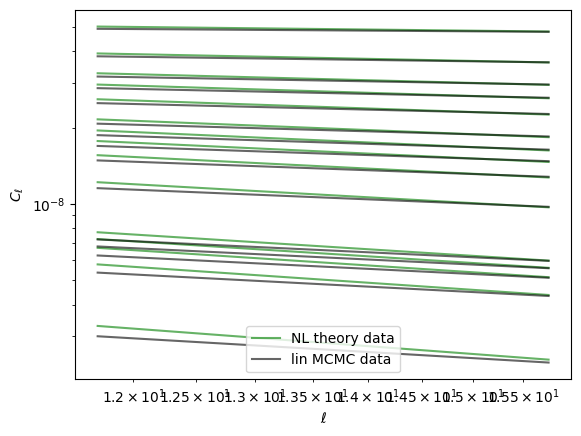

In [385]:
"""Get new Mock data with cuts in ell - ideal case, not implemented"""

h = cosmo_universe["h"]
A_s = cosmo_universe["A_s"]
n_s = cosmo_universe["n_s"]
#print(sampler_scalecut_arr[i, :, 0][-1])
#print(sampler_scalecut_arr[i, :, 1][-1])
#


Omega_c = np.percentile(flat_samples[:, 0], 50)
mu0 = np.percentile(flat_samples[:, 1], 50)
cosmoMCMCstep = ccl.Cosmology(Omega_c = Omega_c, 
                      Omega_b = 0.05,
                      h = h,
                      n_s = n_s,
                      A_s = A_s)

D_theory = (np.array(Cell_linear(ell_min_mockdata, ell_mockdata_cut[-1], n_cut,cosmoMCMCstep,\
                 z , Binned_distribution, P_k_musigma, mu0)[1])).flatten()

for j in range(int(len(D_mockdata)/ell_bin_number)):
    #plt.plot(ell_mockdata_cut[j*n_cut:(j+1)*n_cut], D_mockdata_noise_cut[j*n_cut:(j+1)*n_cut], "r", alpha=0.6)
    plt.plot(ell_mockdata[j*18:j*18 + n_cut], D_mockdata[j*18:j*18 + n_cut], "g", alpha=0.6)
    plt.plot(ell_mockdata_cut[j*n_cut:(j+1)*n_cut], D_theory[j*n_cut:(j+1)*n_cut], "k", alpha=0.6)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xscale('log')
plt.yscale('log')
plt.legend([ "NL theory data", "lin MCMC data"])
plt.show()

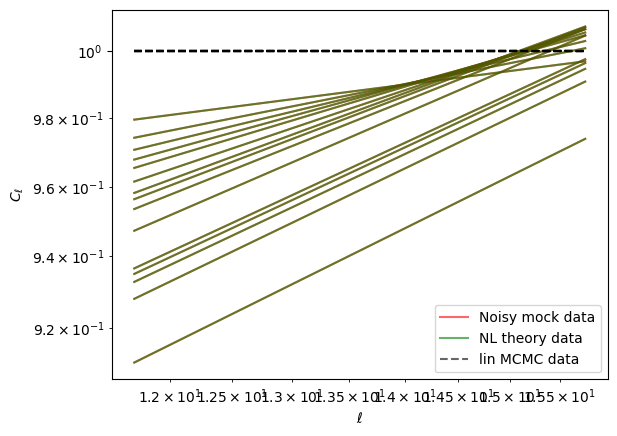

In [389]:
"""Get new Mock data with cuts in ell - ideal case, not implemented"""

h = cosmo_universe["h"]
A_s = cosmo_universe["A_s"]
n_s = cosmo_universe["n_s"]
#print(sampler_scalecut_arr[i, :, 0][-1])
#print(sampler_scalecut_arr[i, :, 1][-1])
#


Omega_c = np.percentile(flat_samples[:, 0], 50)
mu0 = np.percentile(flat_samples[:, 1], 50)
cosmoMCMCstep = ccl.Cosmology(Omega_c = Omega_c, 
                      Omega_b = 0.05,
                      h = h,
                      n_s = n_s,
                      A_s = A_s)

D_theory = (np.array(Cell_linear(ell_min_mockdata, ell_mockdata_cut[-1], n_cut,cosmoMCMCstep,\
                 z , Binned_distribution, P_k_musigma, mu0)[1])).flatten()

for j in range(int(len(D_mockdata)/ell_bin_number)):
    plt.plot(ell_mockdata_cut[j*n_cut:(j+1)*n_cut], D_theory[j*n_cut:(j+1)*n_cut]/D_mockdata_cut[j*n_cut:(j+1)*n_cut], "r", alpha=0.6)
    plt.plot(ell_mockdata[j*18:j*18 + n_cut], D_theory[j*n_cut:(j+1)*n_cut]/D_mockdata[j*18:j*18 + n_cut], "g", alpha=0.6)
    plt.plot(ell_mockdata_cut[j*n_cut:(j+1)*n_cut], np.ones(len(D_theory[j*n_cut:(j+1)*n_cut])), "k--", alpha=0.6)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xscale('log')
plt.yscale('log')
plt.legend(["Noisy mock data", "NL theory data", "lin MCMC data"])

plt.show()

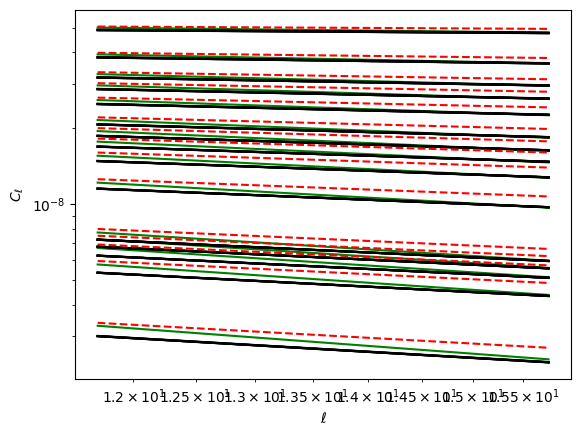

In [392]:

h = cosmo_universe["h"]
A_s = cosmo_universe["A_s"]
n_s = cosmo_universe["n_s"]
#print(sampler_scalecut_arr[i, :, 0][-1])
#print(sampler_scalecut_arr[i, :, 1][-1])
#

for j in range(int(len(D_mockdata)/ell_bin_number)):
    plt.plot(ell_mockdata_cut[j*n_cut:(j+1)*n_cut], D_mockdata_cut[j*n_cut:(j+1)*n_cut], "g", alpha=1)
    #plt.plot(ell_mockdata[j*18:j*18 + n_cut], D_mockdata[j*18:j*18 + n_cut], "g", alpha=1)

for i in range(50):
    Omega_c = flat_samples[i, 0]
    mu0 = flat_samples[i, 1]
    cosmoMCMCstep = ccl.Cosmology(Omega_c = Omega_c, 
                          Omega_b = 0.05,
                          h = h,
                          n_s = n_s,
                          A_s = A_s)
    
    D_theory = (np.array(Cell_linear(ell_min_mockdata, ell_mockdata_cut[-1], n_cut,cosmoMCMCstep,\
                     z , Binned_distribution, P_k_musigma, mu0)[1])).flatten()
    
    for j in range(int(len(D_mockdata)/ell_bin_number)):
        plt.plot(ell_mockdata_cut[j*n_cut:(j+1)*n_cut], D_theory[j*n_cut:(j+1)*n_cut], "k", alpha=0.1)

Omega_c = cosmo_universe["Omega_c"]
mu0 = 0.0
cosmoMCMCstep = ccl.Cosmology(Omega_c = Omega_c, 
                      Omega_b = 0.05,
                      h = h,
                      n_s = n_s,
                      A_s = A_s)

D_theory_real = (np.array(Cell_linear(ell_min_mockdata, ell_mockdata_cut[-1], n_cut,cosmoMCMCstep,\
                 z , Binned_distribution, P_k_musigma, mu0)[1])).flatten()

for j in range(int(len(D_mockdata)/ell_bin_number)):
    plt.plot(ell_mockdata_cut[j*n_cut:(j+1)*n_cut], D_theory_real[j*n_cut:(j+1)*n_cut], "r--")

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xscale('log')
plt.yscale('log')
plt.show()

## 8d. combined contour plot

In [406]:
sampler_nocut_arr = np.load("chains/sample_nocut.npy")
sampler_scalecut_arr = np.load("chains/sample_scalecut.npy")
sampler_PCA_arr = np.load("chains/sample_PCA.npy")

(4500, 2)


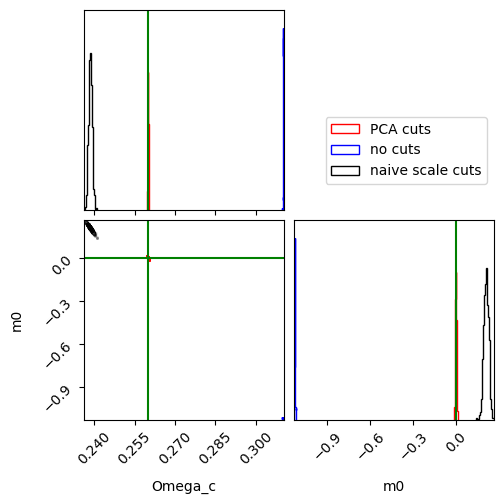

In [407]:
# Plot (a)
burnin = 100
final_length = len(sampler_PCA_arr)*(len(sampler_PCA_arr[0])-burnin)

flat_samples = sampler_PCA_arr[:,burnin:].reshape(final_length,2)
labels = ["Omega_c", "m0"]
print(flat_samples.shape)


figure = corner.corner(
    flat_samples, labels=labels, color="r"
);

ndim = 2

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

value1 = [cosmo_universe["Omega_c"], 0.0]

# Plot (b)
burnin = 100
final_length = len(sampler_nocut_arr)*(len(sampler_nocut_arr[0])-burnin)

flat_samples = sampler_nocut_arr[:,burnin:].reshape(final_length,2)

corner.corner(flat_samples, fig=figure, color="b")

# Plot (c)
burnin = 100
final_length = len(sampler_scalecut_arr)*(len(sampler_scalecut_arr[0])-burnin)

flat_samples = sampler_scalecut_arr[:,burnin:].reshape(final_length,2)
corner.corner(flat_samples, fig=figure)


# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axhline(value1[yi], color="g")

plt.legend(["PCA cuts","no cuts", "naive scale cuts"], bbox_to_anchor=(1.0, 1.55))

(4500, 2)
(4500, 2)
(4500, 2)


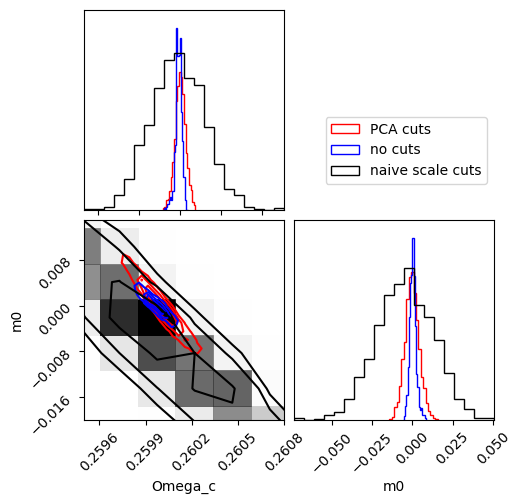

In [418]:
# Plot (a)
burnin = 100
final_length = len(sampler_PCA_arr)*(len(sampler_PCA_arr[0])-burnin)

flat_samples = sampler_PCA_arr[:,burnin:].reshape(final_length,2)
labels = ["Omega_c", "m0"]
print(flat_samples.shape)

figure = corner.corner(
    flat_samples, labels=labels, color="r",plot_datapoints=False
);

ndim = 2

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

value1 = [cosmo_universe["Omega_c"], 0.0]

# Plot (b)
burnin = 100
final_length = len(sampler_nocut_arr)*(len(sampler_nocut_arr[0])-burnin)

flat_samples = sampler_nocut_arr[:,burnin:].reshape(final_length,2) + np.array([-0.0503,1.128])

print(flat_samples.shape)
corner.corner(flat_samples, fig=figure, color="b", plot_datapoints=False)

# Plot (c)
burnin = 100
final_length = len(sampler_scalecut_arr)*(len(sampler_scalecut_arr[0])-burnin)

flat_samples = sampler_scalecut_arr[:,burnin:].reshape(final_length,2) + np.array([0.0215,-0.215])

print(flat_samples.shape)
corner.corner(flat_samples, fig=figure, plot_datapoints=False)


# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.set_xlim(0.2595,0.2608)
        ax.set_ylim(-0.02,0.015)

plt.legend(["PCA cuts","no cuts", "naive scale cuts"], bbox_to_anchor=(1.0, 1.55))